# KMP Algorithm: Graphical Analysis

This notebook provides a graphical performance analysis of the KMP (Knuth–Morris–Pratt) exact pattern matching algorithm for DNA sequences.

Notation:
- n = length of the text (len(text))
- m = length of the pattern (len(pattern))

Reference and attribution:
- KMP algorithm and LPS (computeLPSArray) flow adapted from GeeksforGeeks (ported from C++):
  https://www.geeksforgeeks.org/kmp-algorithm-for-pattern-searching/

In [1]:
# Setup: imports and environment
import os, sys, time, json

# Ensure this notebook can import from the KMP package directory
sys.path.append(os.path.abspath("."))  # current folder (should be STARK/KMP)

try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys as _sys
    !{_sys.executable} -m pip install -q matplotlib
    import matplotlib.pyplot as plt

from kmp import KMP, search_multiple_patterns, find_approximate_matches
from utils import generate_random_dna

plt.rcParams["figure.figsize"] = (8, 4.8)
plt.rcParams["axes.grid"] = True

def time_call(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    return result, (end - start)

### About this cell
- Sets up imports, plotting defaults, and a small `time_call` helper used for timing functions consistently.
- Imports KMP utilities from local files so you can run the notebook standalone within the `KMP/` folder.

In [ ]:
import os
import gzip
from typing import List, Optional

# --- CONFIGURATION ---
# Provide a direct file path OR a directory containing FASTA files.
# Examples:
#   DATASET_PATH = "../DnA_dataset/ncbi_dataset/data/GCF_000005845.2/genomic.fna"
#   DATASET_PATH = "../DnA_dataset" 
DATASET_PATH = os.path.abspath(os.path.join('..', 'DnA_dataset'))

# Optionally cap how many base pairs to load (None = full)
MAX_BP = None 

FASTA_EXTS = ('.fna', '.fa', '.fasta', '.fna.gz', '.fa.gz', '.fasta.gz')

def resolve_fasta_path(path: str) -> Optional[str]:
    """
    If path is a file, return it. 
    If path is a dir, find the first FASTA file inside it (recursive).
    """
    if not os.path.exists(path):
        return None

    # 1. It is a direct file
    if os.path.isfile(path):
        if path.lower().endswith(FASTA_EXTS):
            return path
        return None

    # 2. It is a directory (search inside)
    if os.path.isdir(path):
        for dirpath, _, filenames in os.walk(path):
            # Sort to ensure deterministic selection
            for fn in sorted(filenames):
                if fn.lower().endswith(FASTA_EXTS):
                    return os.path.join(dirpath, fn)
    
    return None

def read_fasta_concat(path: str, limit: int | None = None) -> str:
    """Concatenate all non-header lines from a FASTA file (gz supported)."""
    seq_parts: List[str] = []
    opener = gzip.open if path.endswith('.gz') else open
    
    try:
        with opener(path, 'rt') as fh:
            for line in fh:
                if line.startswith('>'):
                    continue
                s = line.strip()
                if s:
                    seq_parts.append(s)
                    
                # Optimization: Stop reading if we loosely exceed limit (optional)
                # (Strict slicing happens at return to be exact)
                if limit and sum(len(p) for p in seq_parts) >= limit:
                    break
    except Exception as e:
        print(f"Error reading file: {e}")
        return ""

    seq = ''.join(seq_parts).upper()
    return seq if limit is None else seq[:limit]

# --- EXECUTION ---
final_file_path = resolve_fasta_path(DATASET_PATH)

if not final_file_path:
    raise FileNotFoundError(
        f"No valid FASTA files found at or inside: {DATASET_PATH}\n"
        f"Ensure the path exists and contains files ending in {FASTA_EXTS}"
    )

print(f"Selected FASTA: {final_file_path}")
TEXT_DATA = read_fasta_concat(final_file_path, limit=MAX_BP)
print(f"Loaded sequence length: {len(TEXT_DATA):,}")

Selected FASTA: /home/rishabh/Desktop/sem3/aad/project/STARK/DnA_dataset/ncbi_dataset/data/GCA_000005845.2/GCA_000005845.2_ASM584v2_genomic.fna
Loaded sequence length: 4,641,652


### About this cell
- Configures dataset paths and selection knobs:
  - `DATA_ROOT`, `SELECT_STRAIN`, `SELECT_FASTA`, optional `MAX_BP`.
- Provides helpers to list and load FASTA (.fa/.fna, gz supported).
- Loads the chosen strand into `TEXT_DATA` and prints its length.

## Experiment 1: Impact of Pattern Length (fixed text length)

We fix the text length (n) and vary pattern length (m).

Method:
- Run the code on the given dna strand
- For each m in a range, take a substring from the text as pattern (to ensure matches exist)
- Run KMP.search and record time
- Plot m vs. time (ms)

In [3]:
import statistics as stats

# Experiment 1 now runs on dataset strand TEXT_DATA loaded above

def benchmark_pattern_length(text, pattern_lengths=(5, 10, 20, 50, 100, 200, 400, 800), trials=50):
    n = len(text)
    results = []
    for m in pattern_lengths:
        # Use a slice from text to ensure at least one match
        if n >= 1000 + m:
            pattern = text[1000:1000+m]
        else:
            pattern = text[:m]
        kmp = KMP(pattern)
        times = []
        for _ in range(trials):
            _, t = time_call(kmp.search, text)
            times.append(t)
        results.append({
            "pattern_length": m,
            "n": n,
            "time_seconds_mean": stats.mean(times),
            "time_seconds_min": min(times),
            "time_seconds_max": max(times),
            "matches_found": len(kmp.search(text)),
        })
    return results

pattern_len_results = benchmark_pattern_length(TEXT_DATA)
pattern_len_results

[{'pattern_length': 5,
  'n': 4641652,
  'time_seconds_mean': 0.48485010545977275,
  'time_seconds_min': 0.4785005119993002,
  'time_seconds_max': 0.501038084999891,
  'matches_found': 6929},
 {'pattern_length': 10,
  'n': 4641652,
  'time_seconds_mean': 0.48465732388052857,
  'time_seconds_min': 0.4797360880038468,
  'time_seconds_max': 0.5014439489968936,
  'matches_found': 3},
 {'pattern_length': 20,
  'n': 4641652,
  'time_seconds_mean': 0.4838298195392417,
  'time_seconds_min': 0.4790302730034455,
  'time_seconds_max': 0.5063567729957867,
  'matches_found': 1},
 {'pattern_length': 50,
  'n': 4641652,
  'time_seconds_mean': 0.48672878168013994,
  'time_seconds_min': 0.47796243600168964,
  'time_seconds_max': 0.5152139639976667,
  'matches_found': 1},
 {'pattern_length': 100,
  'n': 4641652,
  'time_seconds_mean': 0.48233835000006364,
  'time_seconds_min': 0.4770944990013959,
  'time_seconds_max': 0.5088693159996183,
  'matches_found': 1},
 {'pattern_length': 200,
  'n': 4641652,
  

### About Experiment 1 (pattern length)
- Benchmarks KMP on the loaded strand (`TEXT_DATA`) while varying pattern length m.
- Patterns are slices from the text to guarantee matches.
- Output: a list of dicts with mean/min/max time (s), matches, and n.

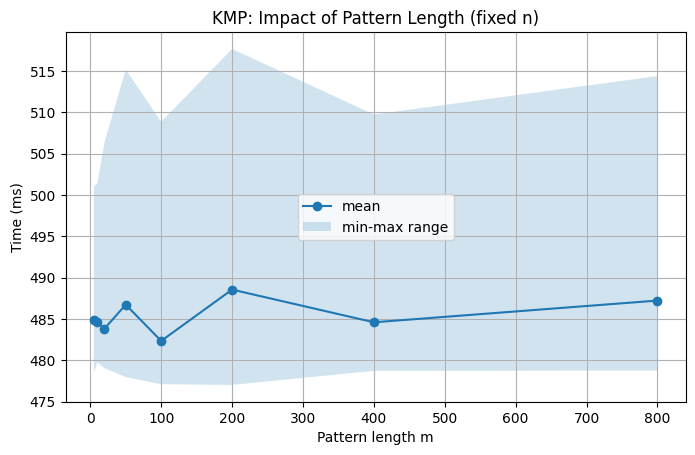

In [5]:
# Plot: m vs time (ms)
ms = [r["time_seconds_mean"] * 1000 for r in pattern_len_results]
ms_min = [r["time_seconds_min"] * 1000 for r in pattern_len_results]
ms_max = [r["time_seconds_max"] * 1000 for r in pattern_len_results]
m_values = [r["pattern_length"] for r in pattern_len_results]

plt.figure()
plt.plot(m_values, ms, marker='o', label='mean')
plt.fill_between(m_values, ms_min, ms_max, alpha=0.2, label='min-max range')
plt.xlabel('Pattern length m')
plt.ylabel('Time (ms)')
plt.title('KMP: Impact of Pattern Length (fixed n)')
plt.legend()
plt.show()

### About this plot
- Plots m vs time (ms) using mean with a min–max band from Experiment 1 results.
- Expect near-flat trend vs m on fixed n for typical motifs due to KMP’s O(n+m) behavior.

## Experiment 2: Impact of Text Length (fixed pattern length)

We fix the pattern length (m) and vary the text length (n).

Method:
- For each n in a range, generate random DNA text
- Keep a fixed m and select a known-in-text pattern
- Run KMP.search and record time
- Plot n vs. time (ms) and n vs. speed (million chars/sec)

In [6]:
import statistics as stats

# Experiment 2 now slices the loaded dataset strand TEXT_DATA to vary n

def benchmark_text_length_from_text(full_text, text_lengths=(100_000, 500_000, 1_000_000, 2_000_000), m=50, trials=10):
    N = len(full_text)
    results = []
    for n in text_lengths:
        if n > N:
            # skip sizes beyond available sequence
            continue
        text = full_text[:n]
        # Choose a pattern from within the text slice to ensure matches
        start = 100 if n > (100 + m) else max(0, n - m)
        pattern = text[start:start+m]
        m_eff = len(pattern)
        kmp = KMP(pattern)
        times = []
        for _ in range(trials):
            _, t = time_call(kmp.search, text)
            times.append(t)
        t_mean = stats.mean(times)
        cps = (n / t_mean) if t_mean > 0 else float('inf')
        results.append({
            "n": n,
            "pattern_length": m_eff,
            "time_seconds_mean": t_mean,
            "time_seconds_min": min(times),
            "time_seconds_max": max(times),
            "chars_per_second": cps,
            "Mchars_per_second": cps / 1e6
        })
    return results

text_len_results = benchmark_text_length_from_text(TEXT_DATA)
text_len_results

[{'n': 100000,
  'pattern_length': 50,
  'time_seconds_mean': 0.011168832900148118,
  'time_seconds_min': 0.010428205998323392,
  'time_seconds_max': 0.012004854004771914,
  'chars_per_second': 8953486.984183803,
  'Mchars_per_second': 8.953486984183803},
 {'n': 500000,
  'pattern_length': 50,
  'time_seconds_mean': 0.053256241601047805,
  'time_seconds_min': 0.05146804099786095,
  'time_seconds_max': 0.05503120499633951,
  'chars_per_second': 9388570.8973906,
  'Mchars_per_second': 9.3885708973906},
 {'n': 1000000,
  'pattern_length': 50,
  'time_seconds_mean': 0.10731267780065537,
  'time_seconds_min': 0.10428493099607294,
  'time_seconds_max': 0.10898338200058788,
  'chars_per_second': 9318563.477258535,
  'Mchars_per_second': 9.318563477258536},
 {'n': 2000000,
  'pattern_length': 50,
  'time_seconds_mean': 0.21698382629983826,
  'time_seconds_min': 0.20831374599947594,
  'time_seconds_max': 0.22602560999803245,
  'chars_per_second': 9217276.854710396,
  'Mchars_per_second': 9.2172

### About Experiment 2 (text length)
- Varies n by slicing the loaded strand (`TEXT_DATA`) to the requested lengths.
- Picks a pattern from within each slice so matches are guaranteed.
- Computes mean/min/max time and throughput (M chars/sec).

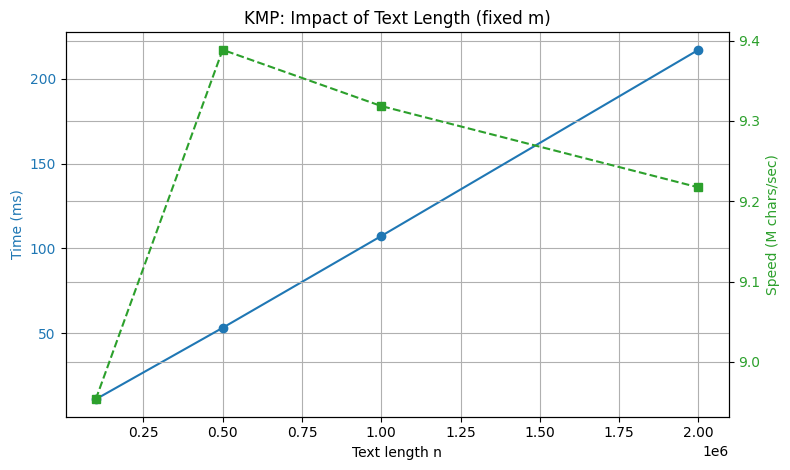

In [9]:
# Plot: n vs time (ms) and speed (M chars/sec)
n_values = [r["n"] for r in text_len_results]
time_ms = [r["time_seconds_mean"] * 1000 for r in text_len_results]
speed_mcs = [r["Mchars_per_second"] for r in text_len_results]

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Text length n')
ax1.set_ylabel('Time (ms)', color=color)
ax1.plot(n_values, time_ms, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Speed (M chars/sec)', color=color)
ax2.plot(n_values, speed_mcs, marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('KMP: Impact of Text Length (fixed m)')
fig.tight_layout()
plt.show()

### About this plot
- Left Y-axis: time (ms) vs n; Right Y-axis: speed (million chars/sec).
- Expect near-linear time vs n; speed should stabilize at larger n reflecting KMP throughput.

## Experiment 3: Multiple Pattern Search

We evaluate total time to search for multiple patterns against the same text.

Method:
- Generate a fixed text of length n
- Create k patterns with varying m (by slicing from text)
- Use `search_multiple_patterns` and measure total time
- Summarize counts and total time

In [8]:
# Experiment 3 now searches multiple patterns on the dataset strand TEXT_DATA

def benchmark_multiple_patterns_from_text(text, k=25, base_m=10):
    n = len(text)
    patterns = []
    for i in range(k):
        m = base_m + 5 * i
        if m >= n:
            break
        start = (i * 100) % max(1, (n - m))
        patterns.append(text[start:start+m])  # ensure matches in text
    matches_dict, t = time_call(search_multiple_patterns, text, patterns)
    total_matches = sum(len(v) for v in matches_dict.values())
    return {
        "n": n,
        "k": len(patterns),
        "total_time_ms": t * 1000,
        "total_matches": total_matches,
        "details": {p: len(matches_dict[p]) for p in patterns}
    }

mp_results = benchmark_multiple_patterns_from_text(TEXT_DATA)
mp_results

{'n': 4641652,
 'k': 25,
 'total_time_ms': 12215.816169999016,
 'total_matches': 33,
 'details': {'AGCTTTTCAT': 9,
  'TAAAATTTTATTGAC': 1,
  'TAGCACCACCATTACCACCA': 1,
  'CTTTTTTTTTCGACCAAAGGTAACG': 1,
  'ATATTCTGGAAAGCAATGCCAGGCAGGGGC': 1,
  'TAGCGGCCAGGATGCTTTACCCAATATCAGCGATG': 1,
  'CAATTGAAAACTTTCGTCGATCAGGAATTTGCCCAAATAA': 1,
  'TGATTTGCCGTGGCGAGAAAATGTCGATCGCCATTATGGCCGGCG': 1,
  'GGCAGTGGGGCATTACCTCGAATCTACCGTCGATATTGCTGAGTCCACCC': 1,
  'GGTTTCACCGCCGGTAATGAAAAAGGCGAACTGGTGGTGCTTGGACGCAACGGTT': 1,
  'GTTGCGAGATTTGGACGGACGTTGACGGGGTCTATACCTGCGACCCGCGTCAGGTGCCCG': 1,
  'GGAGCTTTCCTACTTCGGCGCTAAAGTTCTTCACCCCCGCACCATTACCCCCATCGCCCAGTTCC': 1,
  'CAAGCACCAGGTACGCTCATTGGTGCCAGCCGTGATGAAGACGAATTACCGGTCAAGGGCATTTCCAATC': 1,
  'GTCCGGGGATGAAAGGGATGGTCGGCATGGCGGCGCGCGTCTTTGCAGCGATGTCACGCGCCCGTATTTCCGTGG': 1,
  'ATACAGCATCAGTTTCTGCGTTCCACAAAGCGACTGTGTGCGAGCTGAACGGGCAATGCAGGAAGAGTTCTACCTGGAAC': 1,
  'CCGCTGGCAGTGACGGAACGGCTGGCCATTATCTCGGTGGTAGGTGATGGTATGCGCACCTTGCGTGGGATCTCGGCGAAATTCT': 1,


### About Experiment 3 (multiple patterns)
- Builds k patterns by slicing different regions/sizes from `TEXT_DATA` to ensure matches.
- Uses `search_multiple_patterns` to search all patterns and measures total time and counts.

## Save Results (optional)

You can save the experiment outputs to JSON for later comparison.

In [10]:
out = {
    "pattern_length": pattern_len_results,
    "text_length": text_len_results,
    "multiple_patterns": mp_results,
}
with open("kmp_nb_results.json", "w") as f:
    json.dump(out, f, indent=2)
print("Saved kmp_nb_results.json")

Saved kmp_nb_results.json


### About this cell
- Saves a compact JSON (`kmp_nb_results.json`) with Experiment 1–3 outputs for reproducibility.
- You can diff these JSONs across runs/strains or use them to re-plot without recomputation.